# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
!which python

/Users/Adnan/miniconda3/envs/carnd-term1/bin/python


## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


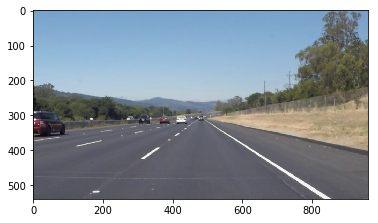

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
counter = 0

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  
# if you wanted to show a single 
#color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [4]:
import os

In [5]:
from itertools import chain
from copy import deepcopy

class Lane(object):
    """
    Domain knowledge for lane recognition and lane filtering.
    We have two lanes and update them using the information we gather.
    """
    
    CRITICAL_SLOPE_CHANGE = 0.1
    MOSTLY_HORIZONTAL_SLOPE = 0.4
    MAX_SLOPE_DIFFERENCE = 0.8
    MAX_DISTANCE_FROM_LINE = 20
    BUFFER_FRAMES = 8
    COLORS = {
        'lane_color': (147,112,219),
        'region_stable': (0,80,60),
        'region_unstable': (255,80,60),
        'left_line': (60,40,220),
        'right_line': (147,112,219)
    }
    THICKNESS = 5
    FIRST_FRAME_LINE_RANGES = {'left_line': range(480), 
                               'right_line': range(480,960)}
    
    # A decision matrix for updating a lane line in order to keep it steady.
    # A weighted average of average lane position from buffer and from the current frame.
    # 0.1 * frame position + 0.9 * avg from buffer: in case of unstable lane.
    # 1 * frame position + 0 * buffer: in case of stable lane.
    DECISION_MAT = [[.1,.9],[1,0]]
    
    left_line = None
    right_line = None
    
    @staticmethod
    def lines_exist():
        return all([Lane.left_line, Lane.right_line])
    
    @staticmethod
    def fit_lane_line(segments):
        """
        Lines interpolation using a linear regression.
        Any order of polynomial can be used, but we limit ourselves with 1st order for now.
        """
        x, y = [], []
    
        for line in segments:
            if line.candidate:
                x_coords = list(range(line.x1, line.x2, 1))
                y_coords = list(map(line.get_y_coord, x_coords))
                x.extend(x_coords)
                y.extend(y_coords)
                
        # Assisted lane lines detection for the 1st video frame
        # This can be definitely improved
        if x != [] and not Lane.lines_exist():
            lane_line = segments[0].lane_line
            coords = np.array([[x, y] for x,y in zip(x, y)
                               if x in Lane.FIRST_FRAME_LINE_RANGES[lane_line]])
            x = coords[:,0]
            y = coords[:,1]
        if x != []:
            poly_coeffs = np.polyfit(x, y, 1)
            return poly_coeffs, list(zip(x, y))
        else: return None, None
    
    @staticmethod
    def update_vanishing_point(left, right):
        equation = left.coeffs - right.coeffs
        x = -equation[1] / equation[0]
        y = np.poly1d(left.coeffs)(x)
        x, y = map(int, [x, y])
        left.vanishing_point = [x, y]
        right.vanishing_point = [x, y]
        
    @staticmethod
    def purge():
        Lane.left_line = None
        Lane.right_line = None
        global counter
        counter = 0
    
    def __init__(self, segments):
        """
        Since lane line can be any order polynomial, I keep all poly coefficients
        in an array -- this is mostly for the future.
        """
        buffer_frames = Lane.BUFFER_FRAMES
        
        # Lane coefficients from the current image
        self.current_lane_line_coeffs, self.points = Lane.fit_lane_line(segments)
        
        if self.current_lane_line_coeffs is None: 
            raise Exception('Cannot initialize lane. No lines detected.')
        
        # Buffer for lane line smoothing
        self.buffer = np.array(buffer_frames * [self.current_lane_line_coeffs])
        
        # Publicly available coefficients of lane line
        self.coeffs = self.buffer[0]
        
        # Stability flag. Set to False if the slope changes too rapidly
        self.stable = True
        
        # Hough lines which belong to this lane line
        self.segments = None
        
        # List of points which belong to this lane line. Transformed from segments
        self.points = None
        
        # Coordinates for drawing this lane line
        self.x1, self.x2, self.y1, self.y2 = 0,0,0,0
        
    @property
    def a(self):
        """
        Slope of the lane line. Not intended for higher order polynomials.
        """
        if len(self.coeffs) > 2: 
            return Exception("You have a higher order polynomial for Lane, but you treat it as a line.")
        return self.coeffs[0]
    
    @property
    def b(self):
        """
        Intercept of the lane line. Not intended for higher order polynomials.
        """
        if len(self.coeffs) > 2: 
            return Exception("You have a higher order polynomial for Lane, but you treat it as a line.")
        return self.coeffs[1]
    
    # The main client method for dealing with lane updates
    def update_lane_line(self, segments):
        average_buffer = np.average(self.buffer, axis=0)
        self.coeffs = np.average(self.buffer, axis=0)
        self.update_current_lane_line_coeffs(segments)
        weights = Lane.DECISION_MAT[self.stable]
        current_buffer_coeffs = np.dot(weights, np.vstack([self.current_lane_line_coeffs, average_buffer]))
        self.buffer = np.insert(self.buffer, 0, current_buffer_coeffs, axis=0)[:-1]
        self.update_lane_line_coords()
    
    def update_current_lane_line_coeffs(self, segments):
        lane_line_coeffs, points = Lane.fit_lane_line(segments)
        if lane_line_coeffs is None:
            lane_line_coeffs = np.average(self.buffer, axis=0)
        if points is not None:
            self.points = points
        average_buffer = np.average(self.buffer, axis=0)
        buffer_slope = average_buffer[0]
        current_slope = lane_line_coeffs[0]
        self.current_lane_line_coeffs = lane_line_coeffs
        if abs(current_slope - buffer_slope) > Lane.CRITICAL_SLOPE_CHANGE:
            self.stable = False
        else: self.stable = True
            
    def update_segments_list(self, segments):
        self.segments = segments
    
    def get_x_coord(self, y):
        return int((y - self.coeffs[1]) / self.coeffs[0])
    
    def update_lane_line_coords(self):
        # Offset to distinguish lines
        visual_offset = 20
        self.y1 = image.shape[1]
        self.x1 = self.get_x_coord(self.y1)
        self.y2 = self.vanishing_point[1] + visual_offset
        self.x2 = self.get_x_coord(self.y2)
          
class Line(object):
    """
    Line: y = ax + b.
    A line can be described by its pair of coordinates (x1, y1), (x2, y2).
    To formalize a line, we need to compute its slope (a) and intercept (b).
    """
    
    def __init__(self, x1, y1, x2, y2):
        if x1 > x2: (x1, y1), (x2, y2) = (x2, y2), (x1, y1)
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
        self.a = self.compute_slope()
        self.b = self.compute_intercept()
        self.lane_line = self.assign_to_lane_line()
        
        
    def __repr__(self):
        return 'Line: x1={}, y1={}, x2={}, y2={}, a={}, b={}, candidate={}, line={}'.format(
                self.x1, self.y1, self.x2, self.y2, round(self.a,2), 
                round(self.b,2), self.candidate, self.lane_line)
    
    def get_coords(self):
        return (self.x1, self.y1, self.x2, self.y2)

    def get_x_coord(self, y):
        return int((y - self.b) / self.a)
    
    def get_y_coord(self, x):
        return int(self.a * x + self.b)
    
    def compute_slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1)
    
    def compute_intercept(self):
        return self.y1 - self.a * self.x1
    
    @property
    def candidate(self):
        """
        A simple domain logic to check whether this hough line can be a candidate 
        for being a segment of a lane line.
        1. The line cannot be horizontal and should have a reasonable slope.
        2. The difference between lane line's slope and this hough line's cannot be too high.
        3. The hough line should not be far from the lane line it belongs to.
        4. The hough line should be below the vanishing point.
        """
        if abs(self.a) < Lane.MOSTLY_HORIZONTAL_SLOPE: return False
        lane_line = getattr(Lane, self.lane_line)
        if lane_line:
            if abs(self.a - lane_line.coeffs[0]) > Lane.MAX_SLOPE_DIFFERENCE: return False
            if self.distance_to_lane_line > Lane.MAX_DISTANCE_FROM_LINE: return False
            if self.y2 < Lane.left_line.vanishing_point[1]: return False
        return True
    
    def assign_to_lane_line(self):
        if self.a < 0.0: return 'left_line'
        else: return 'right_line'
        
    @property
    def distance_to_lane_line(self):
        """
        Reference https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
        """
        lane_line = getattr(Lane, self.lane_line)
        if lane_line is None: return None
        avg_x = (self.x2 + self.x1) / 2
        avg_y = (self.y2 + self.y1) / 2
        distance = abs(lane_line.a * avg_x - avg_y + 
                   lane_line.b) / math.sqrt(lane_line.a ** 2 + 1)
        return distance

In [6]:

def gimp_to_opencv_hsv(*hsv):
    """
    I use GIMP to visualize colors. This is a simple
    GIMP => CV2 HSV format converter.
    """
    return (hsv[0] / 2, hsv[1] / 100 * 255, hsv[2] / 100 * 255)

# A fixed polygon coordinates for the region of interest
ROI_VERTICES = np.array([[(50, 540), (420, 330), (590, 330), 
                      (960 - 50, 540)]], dtype=np.int32)    

# White and yellow color thresholds for lines masking.
# Optional "kernel" key is used for additional morphology
WHITE_LINES = { 'low_th': gimp_to_opencv_hsv(0, 0, 80),
                'high_th': gimp_to_opencv_hsv(359, 10, 100) }

YELLOW_LINES = { 'low_th': gimp_to_opencv_hsv(35, 20, 30),
                 'high_th': gimp_to_opencv_hsv(65, 100, 100),
                 'kernel': np.ones((3,3),np.uint64)}

def get_lane_lines_mask(hsv_image, colors):
    """
    Image binarization using a list of colors. The result is a binary mask
    which is a sum of binary masks for each color.
    """
    masks = []
    for color in colors:
        if 'low_th' in color and 'high_th' in color:
            mask = cv2.inRange(hsv_image, color['low_th'], color['high_th'])
            if 'kernel' in color:
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, color['kernel'])
            masks.append(mask)
        else: raise Exception('High or low threshold values missing')
    if masks:
        return cv2.add(*masks)
    
def hough_line_transform(image, rho, theta, threshold, min_line_length, max_line_gap):
    """
    A modified implementation of a suggested `hough_lines` function which allows 
    Line objects initialization and in-place line filtering.
    Returns a list of Line instances which are considered segments of a lane.
    """
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    if lines is not None:
        filtered_lines = list(filter(lambda l: l.candidate, map(lambda line: Line(*line[0]), lines)))
        return filtered_lines
    else: return None
    
def update_lane(segments):
    if segments is not None:
        left = [segment for segment in segments if segment.lane_line == 'left_line']
        right = [segment for segment in segments if segment.lane_line == 'right_line']
        if not Lane.lines_exist():
            Lane.left_line = Lane(left)
            Lane.right_line = Lane(right)      
        Lane.update_vanishing_point(Lane.left_line, Lane.right_line)
        Lane.left_line.update_lane_line([l for l in left if l.candidate])
        Lane.right_line.update_lane_line([r for r in right if r.candidate])

def image_pipeline(image):
    """
    Main image pipeline with 3 phases:
    * Raw image preprocessing and noise filtering;
    * Lane lines state update with the information gathered in preprocessing phase;
    * Drawing updated lane lines and other objects on image.
    """

    ### Phase 1: Image Preprocessing

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    binary_mask = get_lane_lines_mask(hsv_image, [WHITE_LINES, YELLOW_LINES])

    masked_image = draw_binary_mask(binary_mask, hsv_image)

    blank_image = np.zeros_like(image)

    edges_mask = canny(masked_image, 280, 360)
      
    
    if not Lane.lines_exist():
        edges_mask = region_of_interest(edges_mask, ROI_VERTICES)
    
    edges_image = draw_canny_edges(edges_mask, blank_image)
    
    segments = hough_line_transform(edges_mask, 1, math.pi / 180, 5, 5, 8)
    
    ### Stage 2: Lane lines state update
    
    update_lane(segments)

    ### Stage 3: Drawing

    # Snapshot 1
    out_snap1 = np.zeros_like(image)
    out_snap1 = draw_binary_mask(binary_mask, out_snap1)
    out_snap1 = draw_filtered_lines(segments, out_snap1)
    snapshot1 = cv2.resize(deepcopy(out_snap1), (240,135))
    
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomCounter          = (470,450)
    bottomText             = (430,500)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    global counter
    
    # Snapshot 2
    out_snap2 = np.zeros_like(image)
    out_snap2 = draw_canny_edges(edges_mask, out_snap2)
    out_snap2 = draw_points(Lane.left_line.points, out_snap2, Lane.COLORS['left_line'])
    out_snap2 = draw_points(Lane.right_line.points, out_snap2, Lane.COLORS['right_line'])
    out_snap2 = draw_lane_polygon(out_snap2)
    cv2.putText(out_snap2, str(counter),      
        bottomCounter,      
        font,
        fontScale,    
        fontColor,    
        lineType)
    cv2.putText(out_snap2, 'counter',      
        bottomText,      
        font,
        fontScale,    
        fontColor,    
        lineType)
    
    snapshot2 = cv2.resize(deepcopy(out_snap2), (240,135))
    
    # Augmented image
    output = deepcopy(image)
    output = draw_lane_lines([Lane.left_line, Lane.right_line], output, shade_background=True)
    output = draw_dashboard(output, snapshot1, snapshot2)
    return output

In [7]:
# Simple drawing routines to draw figures on image.

# Though cv2 functions mutate objects in arguments, 
# all routines below explicitly return a 3-channel RGB image.

# Basic signature: draw_some_object(what_to_draw, background_image_to_draw_on, kwargs)

def draw_binary_mask(binary_mask, img):
    if len(binary_mask.shape) != 2: 
        raise Exception('binary_mask: not a 1-channel mask. Shape: {}'.format(str(binary_mask.shape)))
    masked_image = np.zeros_like(img)
    for i in range(3): 
        masked_image[:,:,i] = binary_mask.copy()
    return masked_image

def draw_canny_edges(binary_mask, img):
    return draw_binary_mask(binary_mask, img)

def draw_filtered_lines(lines, img, color=[255, 0, 0], thickness=2):
    """
    Uses the output of `hough_line_transform` function to draw lines on an image.
    """
    if lines is None: return img
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        x1,y1,x2,y2 = line.get_coords()
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return weighted_img(line_img, img)

def draw_points(points, img, color=(255,255,0)):
    if points is None: return img
    for point in points:
        cv2.circle(img, point, 2, color, -1)
    return img

def draw_lane_lines(lane_lines, img, shade_background=False):
    if shade_background: α = 0.8
    else: α = 1.
    lane_line_image = np.zeros_like(img)
    for line in lane_lines:
        line.update_lane_line_coords()
        cv2.line(lane_line_image, (line.x1, line.y1), (line.x2, line.y2), 
                    Lane.COLORS['lane_color'], Lane.THICKNESS)
    return weighted_img(lane_line_image, img, α=α, β=1.)
  
def draw_lane_polygon(img):
    offset_from_lane_edge = 20
    color = Lane.COLORS['region_stable']
    
    if not Lane.lines_exist(): return img

    # Polygon points
    p1 = [Lane.left_line.x1,Lane.left_line.y1]
    p2 = [Lane.left_line.get_x_coord(Lane.left_line.y2 + offset_from_lane_edge),
                                     Lane.left_line.y2 + offset_from_lane_edge]
    p3 = [Lane.right_line.get_x_coord(Lane.left_line.y2 + offset_from_lane_edge),
                                      Lane.right_line.y2 + offset_from_lane_edge]
    p4 = [Lane.right_line.x1,Lane.right_line.y1]
    
    polygon_points = np.array([p1, p2, p3, p4], np.int32).reshape((-1,1,2))
    
    if not Lane.left_line.stable or not Lane.right_line.stable:
        color = Lane.COLORS['region_unstable']
        global counter
        counter = counter + 1
    
    poly_img = np.zeros_like(img)
    cv2.fillPoly(poly_img,[polygon_points], color)
    return weighted_img(img, poly_img)

def draw_dashboard(img, snapshot1, snapshot2):
    # TODO: refactor this
    if not Lane.lines_exist(): return img
    cv2.CV_FILLED = -1
    image_copy = deepcopy(img)
    cv2.rectangle(image_copy, (0,0), (540,175), (0,0,0), cv2.CV_FILLED)
    img = weighted_img(image_copy, img, α=0.3, β=0.7)
    img[20:155,20:260,:] = snapshot1
    img[20:155,280:520,:] = snapshot2
    return img

def draw_on_gray_with_color_mask(img, binary_mask):
    """
    Returns a gray-ish image with colorized parts described in binary_mask.
    img should be a 3-channel image.
    """
    image_gray = grayscale(img)
    mask = np.zeros_like(img)
    color_mask = cv2.bitwise_and(img, img, mask= binary_mask)
    binary_mask_inv = cv2.bitwise_not(binary_mask)
    image_gray = cv2.bitwise_and(image_gray, image_gray, mask=binary_mask_inv)

    output = np.zeros_like(img)
    for i in range(3):
        output[:,:,i] = image_gray
    output = cv2.add(output, color_mask)
    return output

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=0.8, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

/Users/Adnan/miniconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


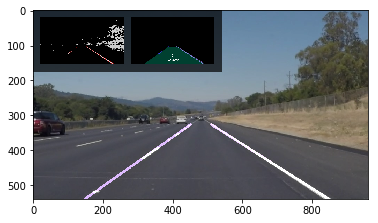

In [10]:
Lane.purge()
plt.imshow(image_pipeline(image))


In [11]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

/Users/Adnan/miniconda3/envs/carnd-term1/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


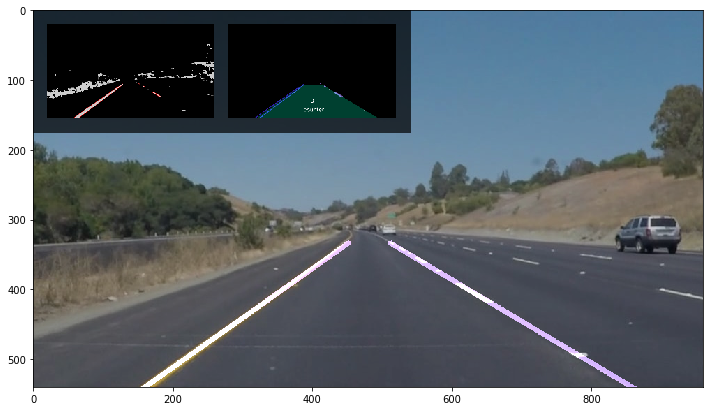

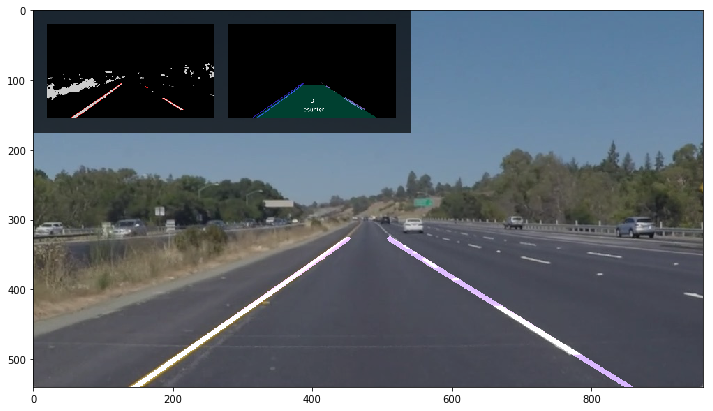

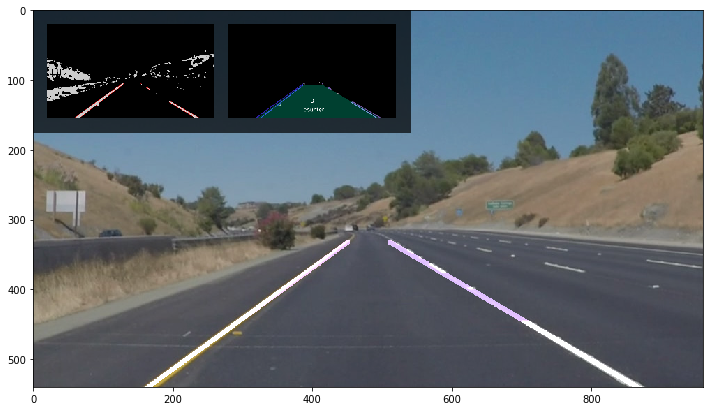

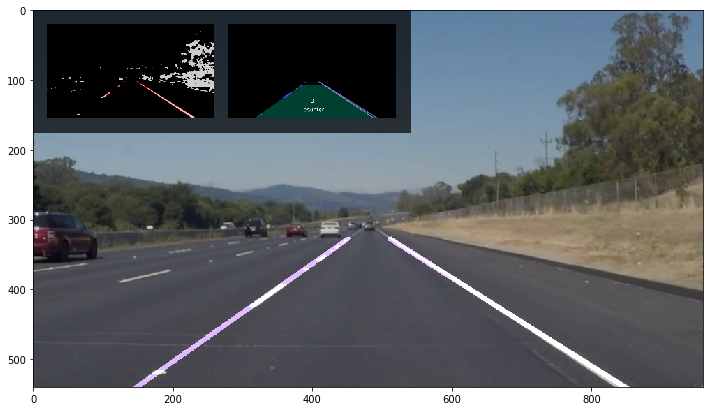

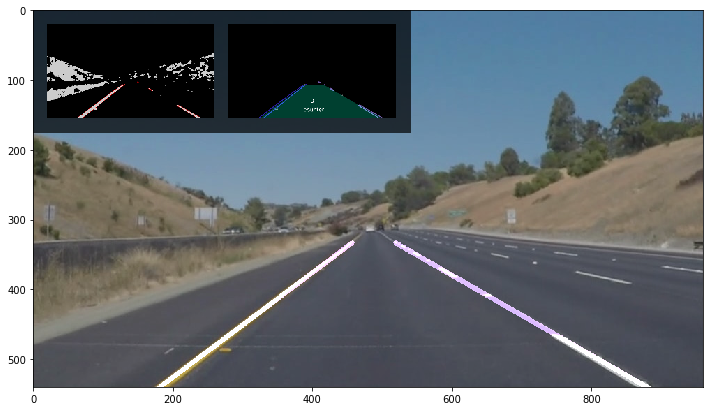

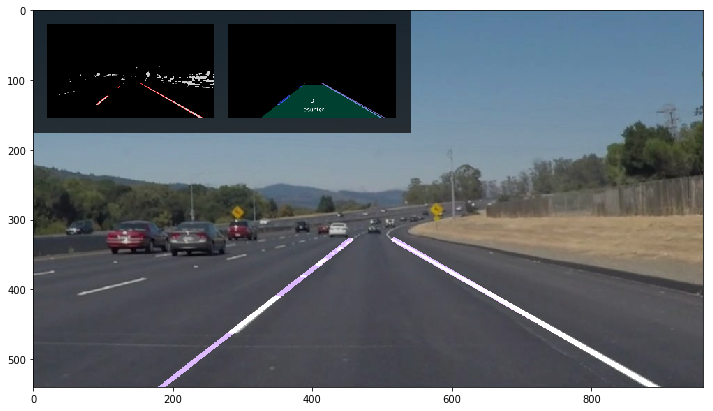

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
    
VERBOSE = False
for img in os.listdir("test_images/"):
    if img.endswith('jpg'):
        Lane.purge()
        plt.figure(figsize=(12,8))
        image = mpimg.imread('test_images/{}'.format(img))
        plt.imshow(image_pipeline(image))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    width = 960
    height = 540
    frame = cv2.resize(image, (960,540))
    return image_pipeline(frame)

Let's try the one with the solid white lane on the right first ...

In [15]:
Lane.purge()
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)#NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 45.5 s, sys: 4.49 s, total: 50 s
Wall time: 12.9 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [17]:
Lane.purge()
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:47<00:00, 14.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 51s, sys: 15.1 s, total: 3min 6s
Wall time: 48.4 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [19]:
Lane.purge()
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:18<00:00, 13.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 8s, sys: 6.36 s, total: 1min 15s
Wall time: 19.1 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## But there is a lot of room for improvement

In [21]:
Lane.purge()
harder_challenge_output = 'test_videos_output/harder_challenge.mp4'
clip4 = VideoFileClip('previous/harder_challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge.mp4
[MoviePy] Writing video test_videos_output/harder_challenge.mp4


100%|█████████▉| 681/682 [00:47<00:00, 11.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge.mp4 

CPU times: user 2min 53s, sys: 15.7 s, total: 3min 9s
Wall time: 48.7 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))